In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import string
import re

import scipy
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import evaluate

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

import torchinfo

import wandb

import time
import os
import shutil
import json
from datetime import datetime

import transformers
from transformers import BertTokenizer, BertModel

from tqdm.notebook import tqdm
tqdm.pandas()

device="cuda"

## Dataset Loading

In [2]:
train_stances = pd.read_csv("./dataset/train_stances.csv")
train_bodies = pd.read_csv("./dataset/train_bodies.csv")

test_stances = pd.read_csv("./dataset/competition_test_stances.csv")
test_bodies = pd.read_csv("./dataset/competition_test_bodies.csv")

Join the two datasets and add a label for related articles

In [3]:
test_df = test_stances.merge(test_bodies, on="Body ID")
test_df["Related"] = (test_df["Stance"] != "unrelated").astype(int)

train_and_val_df = train_stances.merge(train_bodies, on="Body ID")
train_and_val_df["Related"] = (train_and_val_df["Stance"] != "unrelated").astype(int)

For training the stance detection we only want those that are related

In [4]:
train_and_val_df = train_and_val_df[train_and_val_df["Related"] == True]
test_df = test_df[test_df["Related"] == True]

In [5]:
val_split_ratio = 0.2

def split_train_val(df, ratio):
    val_count = int(ratio * df["Body ID"].nunique())
    all_ids = list(df["Body ID"].unique())
    val_body_ids = random.sample(all_ids, val_count)
    train_body_ids = set(all_ids) - set(val_body_ids)
    
    assert len(set(val_body_ids) & train_body_ids) == 0
    
    val_df = df.loc[df["Body ID"].isin(val_body_ids)]
    train_df = df.loc[df["Body ID"].isin(train_body_ids)]
    
    return val_df, train_df

In [6]:
val_df, train_df = split_train_val(train_and_val_df, val_split_ratio)

def prepare_df(df):
    df = df.drop("Body ID", axis=1)
    df = df.reset_index()
    df = df.drop("index", axis=1)
    df["Related"] = df["Stance"] != "unrelated"
    return df

In [7]:
val_df = prepare_df(val_df)
train_df = prepare_df(train_df)
test_df = prepare_df(test_df)

In [8]:
# Most of this from the first practical
additional_specials = ["—", "”", "“", "’", "‘"]

def remove_excess_whitespace(text):
    text = text.replace("\n", " ")
    text = text.replace("\t", " ")
    text = text.replace("\r", " ")
    text = text.strip()
    return text

def remove_punctuation(text):
    punc = str.maketrans('', '', string.punctuation)
    text = text.translate(punc)
    
    for special in additional_specials:
        text = text.replace(special, "")
    
    return text

def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub('', text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub('', text)

def remove_numbers(text):
    numbers = re.compile(r'\d+')
    return numbers.sub('', text)

def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

def apply_cleaning(text, excess=True, punc=True, urls=True, html=True, numbers=True, emojis=True, lower=True):
    if excess:
        text = " ".join(text.split())
        
    if punc:
        text = remove_punctuation(text)
    
    if urls:
        text = remove_urls(text)
    
    if html:
        text = remove_html(text)
    
    if numbers:
        text = remove_numbers(text)
        
    if emojis:
        text = remove_emojis(text)
        
    if lower:
        text = text.lower()
    
    return text

In [9]:
config_remove_excess_whitespace = True
config_remove_punctuation = False
config_remove_urls = True
config_remove_html = True
config_remove_numbers = False
config_remove_emojis = True
config_convert_to_lowercase = False

In [10]:
def process_text(text):
    text = apply_cleaning(
        text, 
        excess=config_remove_excess_whitespace, 
        punc=config_remove_punctuation, 
        urls=config_remove_urls, 
        html=config_remove_html, 
        numbers=config_remove_numbers, 
        emojis=config_remove_emojis, 
        lower=config_convert_to_lowercase
    )
    
    return text

In [11]:
train_df["Processed Headline"] = train_df["Headline"].progress_apply(process_text)
train_df["Processed Body"] = train_df["articleBody"].progress_apply(process_text)

val_df["Processed Headline"] = val_df["Headline"].progress_apply(process_text)
val_df["Processed Body"] = val_df["articleBody"].progress_apply(process_text)

test_df["Processed Headline"] = test_df["Headline"].progress_apply(process_text)
test_df["Processed Body"] = test_df["articleBody"].progress_apply(process_text)

  0%|          | 0/10876 [00:00<?, ?it/s]

  0%|          | 0/10876 [00:00<?, ?it/s]

  0%|          | 0/2551 [00:00<?, ?it/s]

  0%|          | 0/2551 [00:00<?, ?it/s]

  0%|          | 0/7064 [00:00<?, ?it/s]

  0%|          | 0/7064 [00:00<?, ?it/s]

In [12]:
selected_model = "bert-base-uncased"
tokeniser = BertTokenizer.from_pretrained(selected_model)

In [13]:
def concated_headline_body_tokens(headline, body):
    concated = tokeniser(headline, body, truncation="longest_first", padding="max_length", return_tensors="pt")
    input_ids = concated["input_ids"]
    attention_mask = concated["attention_mask"]
    return input_ids, attention_mask

In [14]:
transformers.logging.set_verbosity_error()
train_df[["input_ids", "attention_mask"]] = train_df.progress_apply(lambda row: concated_headline_body_tokens(row["Processed Headline"], row["Processed Body"]), axis="columns", result_type="expand") # type: ignore
transformers.logging.set_verbosity_warning()

  0%|          | 0/10876 [00:00<?, ?it/s]

In [15]:
transformers.logging.set_verbosity_error()
val_df[["input_ids", "attention_mask"]] = val_df.progress_apply(lambda row: concated_headline_body_tokens(row["Processed Headline"], row["Processed Body"]), axis="columns", result_type="expand") # type: ignore
transformers.logging.set_verbosity_warning()

  0%|          | 0/2551 [00:00<?, ?it/s]

In [16]:
transformers.logging.set_verbosity_error()
test_df[["input_ids", "attention_mask"]] = test_df.progress_apply(lambda row: concated_headline_body_tokens(row["Processed Headline"], row["Processed Body"]), axis="columns", result_type="expand") # type: ignore
transformers.logging.set_verbosity_warning()

  0%|          | 0/7064 [00:00<?, ?it/s]

In [17]:
labels2id = {
    "agree": 0,
    "disagree": 1,
    "discuss": 2
}

In [18]:
train_labels = np.array([labels2id[x] for x in train_df["Stance"].values])
train_labels_tensor = torch.LongTensor(train_labels).unsqueeze(1)
train_labels_tensor.shape

torch.Size([10876, 1])

In [19]:
val_labels = np.array([labels2id[x] for x in val_df["Stance"].values])
val_labels_tensor = torch.LongTensor(val_labels).unsqueeze(1)
val_labels_tensor.shape

torch.Size([2551, 1])

In [20]:
test_labels = np.array([labels2id[x] for x in test_df["Stance"].values])
test_labels_tensor = torch.LongTensor(test_labels).unsqueeze(1)
test_labels_tensor.shape

torch.Size([7064, 1])

In [21]:
unique_class_labels = np.unique(train_labels)
class_weights = compute_class_weight("balanced", classes=unique_class_labels, y=train_labels)
class_weights_tensor = torch.from_numpy(class_weights)
class_weights_tensor

tensor([1.2145, 5.4353, 0.5018], dtype=torch.float64)

In [22]:
# From Practical
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
#     cm = confusion_matrix(y_test, y_pred)

#     # Create a dataframe with the confusion matrix values
#     df_cm = pd.DataFrame(cm, range(cm.shape[0]),
#                   range(cm.shape[1]))

#     # Plot the confusion matrix
#     sns.set(font_scale=1.4) # for label size
#     sns.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10}) # font size
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", display_labels=list(labels2id.keys()))
    plt.show()

In [23]:
class TransformerTokenDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx] 
        }

        return item
    
    def get_labels(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)

In [24]:
train_transformer_input_ids = torch.concat(list(train_df["input_ids"].values))
train_transformer_attention_masks = torch.concat(list(train_df["attention_mask"].values))
train_dataset = TransformerTokenDataset(train_transformer_input_ids, train_transformer_attention_masks, train_labels_tensor)

In [25]:
val_transformer_input_ids = torch.concat(list(val_df["input_ids"].values))
val_transformer_attention_masks = torch.concat(list(val_df["attention_mask"].values))
val_dataset = TransformerTokenDataset(val_transformer_input_ids, val_transformer_attention_masks, val_labels_tensor)

In [26]:
test_transformer_input_ids = torch.concat(list(test_df["input_ids"].values))
test_transformer_attention_masks = torch.concat(list(test_df["attention_mask"].values))
test_dataset = TransformerTokenDataset(test_transformer_input_ids, test_transformer_attention_masks, test_labels_tensor)

In [27]:
batch_size = 8

In [28]:
train_df["Stance"].value_counts(normalize=True)#.plot(kind="bar")

discuss     0.664215
agree       0.274458
disagree    0.061328
Name: Stance, dtype: float64

# On to Training...

In [142]:
import my_trainer
import importlib
importlib.reload(my_trainer)

<module 'my_trainer' from 'F:\\Documents\\Development\\GitHub\\natural-language-processing-y4\\code\\my_trainer.py'>

In [143]:
1/0

ZeroDivisionError: division by zero

In [144]:
import gc

# model_trainer.model = None

model_trainer = None
bert = None

gc.collect()

with torch.no_grad():
    torch.cuda.empty_cache()

## Practical: GRU

In [114]:
class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, ids, mask):
        embedded = self.bert(input_ids=ids, attention_mask=mask)[0]
        
        # print(embedded.shape)
        
        _, hidden = self.rnn(embedded)
    
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        
        output = self.out(hidden)        
        
        return output

In [117]:
bert = BertModel.from_pretrained(selected_model)
bert = bert.to(device)

model_trainer = my_trainer.TransformerBasedModelTrainer(
    model_class=BERTGRUSentiment,
    model_transformer=bert,
    model_freeze_transformer=False,
    model_config={
        "hidden_dim": 256,
        "output_dim": 3,
        "n_layers": 2,
        "bidirectional": True,
        "dropout": 0.25
    },
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 10 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=100,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn="inverse",
    no_improvement_epochs_stop=3,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0"
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Initialised
Model Initialised
Loss Initialised
Unique labels [0, 1, 2]
Calculated inverse
Distribution [3.6435510887772193, 16.30584707646177, 1.5055370985603544]
Normalised Distribution [0.16982344826390317, 0.7600044873579476, 0.07017206437814937]
Train Data Sampler Initialised
Dataloaders Initialised
Dumped Config


[2023-04-12 14:12:19] Starting epoch 1
[2023-04-12 14:12:19] Starting epoch training
[2023-04-12 14:12:19] Set model to train mode


  0%|          | 0/1359 [00:00<?, ?it/s]

[2023-04-12 14:12:43][1:40] Loss: 0.736
[2023-04-12 14:13:07][1:80] Loss: 0.718
[2023-04-12 14:13:32][1:120] Loss: 0.536
[2023-04-12 14:13:57][1:160] Loss: 0.562
[2023-04-12 14:14:21][1:200] Loss: 0.532
[2023-04-12 14:14:47][1:240] Loss: 0.517
[2023-04-12 14:15:11][1:280] Loss: 0.459
[2023-04-12 14:15:35][1:320] Loss: 0.508
[2023-04-12 14:15:59][1:360] Loss: 0.407
[2023-04-12 14:16:22][1:400] Loss: 0.437
[2023-04-12 14:16:46][1:440] Loss: 0.432
[2023-04-12 14:17:10][1:480] Loss: 0.369
[2023-04-12 14:17:34][1:520] Loss: 0.372
[2023-04-12 14:17:58][1:560] Loss: 0.305
[2023-04-12 14:18:21][1:600] Loss: 0.372
[2023-04-12 14:18:45][1:640] Loss: 0.240
[2023-04-12 14:19:09][1:680] Loss: 0.320
[2023-04-12 14:19:33][1:720] Loss: 0.348
[2023-04-12 14:19:57][1:760] Loss: 0.320
[2023-04-12 14:20:20][1:800] Loss: 0.328
[2023-04-12 14:20:44][1:840] Loss: 0.326
[2023-04-12 14:21:08][1:880] Loss: 0.337
[2023-04-12 14:21:32][1:920] Loss: 0.289
[2023-04-12 14:21:55][1:960] Loss: 0.373
[2023-04-12 14:22:

  0%|          | 0/319 [00:00<?, ?it/s]

[2023-04-12 14:26:56] Set model to train mode


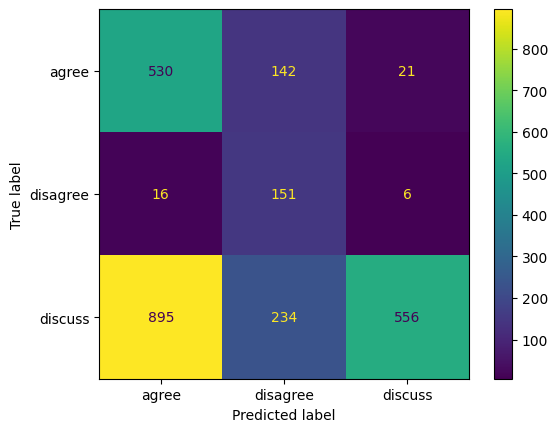

[2023-04-12 14:26:59] Classification Report:
[2023-04-12 14:26:59]               precision    recall  f1-score   support

           0       0.37      0.76      0.50       693
           1       0.29      0.87      0.43       173
           2       0.95      0.33      0.49      1685

    accuracy                           0.48      2551
   macro avg       0.54      0.66      0.47      2551
weighted avg       0.75      0.48      0.49      2551

[2023-04-12 14:26:59] Epoch Accuracy {'accuracy': 0.4849078792630341}
[2023-04-12 14:26:59] Finished validation evaluation
[2023-04-12 14:26:59] Beat best validation loss, new validation loss: 1.194500881255981 (surpassed 1000000000.0 from epoch -1)
[2023-04-12 14:27:00] Saved best model
[2023-04-12 14:27:00] Logged to wandb
[2023-04-12 14:27:00] Starting epoch 2
[2023-04-12 14:27:00] Starting epoch training
[2023-04-12 14:27:00] Set model to train mode


  0%|          | 0/1359 [00:00<?, ?it/s]

[2023-04-12 14:27:24][2:40] Loss: 0.215
[2023-04-12 14:27:48][2:80] Loss: 0.232
[2023-04-12 14:28:12][2:120] Loss: 0.223
[2023-04-12 14:28:35][2:160] Loss: 0.230
[2023-04-12 14:28:59][2:200] Loss: 0.299
[2023-04-12 14:29:23][2:240] Loss: 0.182
[2023-04-12 14:29:46][2:280] Loss: 0.177
[2023-04-12 14:30:10][2:320] Loss: 0.159
[2023-04-12 14:30:34][2:360] Loss: 0.197
[2023-04-12 14:30:57][2:400] Loss: 0.176
[2023-04-12 14:31:21][2:440] Loss: 0.218
[2023-04-12 14:31:45][2:480] Loss: 0.162
[2023-04-12 14:32:08][2:520] Loss: 0.165
[2023-04-12 14:32:32][2:560] Loss: 0.272
[2023-04-12 14:32:56][2:600] Loss: 0.175
[2023-04-12 14:33:19][2:640] Loss: 0.240
[2023-04-12 14:33:43][2:680] Loss: 0.191
[2023-04-12 14:34:06][2:720] Loss: 0.184
[2023-04-12 14:34:30][2:760] Loss: 0.131
[2023-04-12 14:34:54][2:800] Loss: 0.246
[2023-04-12 14:35:17][2:840] Loss: 0.177
[2023-04-12 14:35:41][2:880] Loss: 0.218
[2023-04-12 14:36:05][2:920] Loss: 0.158
[2023-04-12 14:36:28][2:960] Loss: 0.180
[2023-04-12 14:36:

  0%|          | 0/319 [00:00<?, ?it/s]

[2023-04-12 14:41:27] Set model to train mode


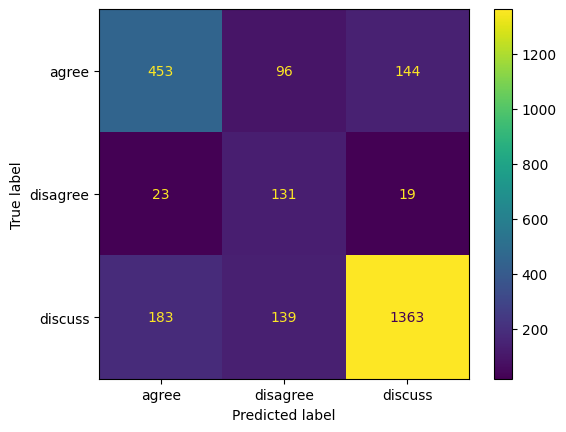

[2023-04-12 14:41:31] Classification Report:
[2023-04-12 14:41:31]               precision    recall  f1-score   support

           0       0.69      0.65      0.67       693
           1       0.36      0.76      0.49       173
           2       0.89      0.81      0.85      1685

    accuracy                           0.76      2551
   macro avg       0.65      0.74      0.67      2551
weighted avg       0.80      0.76      0.78      2551

[2023-04-12 14:41:31] Epoch Accuracy {'accuracy': 0.7632301058408467}
[2023-04-12 14:41:31] Finished validation evaluation
[2023-04-12 14:41:31] Beat best validation loss, new validation loss: 0.7187516227843339 (surpassed 1.194500881255981 from epoch 1)
[2023-04-12 14:41:32] Saved best model
[2023-04-12 14:41:32] Logged to wandb
[2023-04-12 14:41:32] Starting epoch 3
[2023-04-12 14:41:32] Starting epoch training
[2023-04-12 14:41:32] Set model to train mode


  0%|          | 0/1359 [00:00<?, ?it/s]

[2023-04-12 14:41:56][3:40] Loss: 0.155
[2023-04-12 14:42:19][3:80] Loss: 0.130
[2023-04-12 14:42:43][3:120] Loss: 0.169
[2023-04-12 14:43:07][3:160] Loss: 0.107
[2023-04-12 14:43:30][3:200] Loss: 0.181
[2023-04-12 14:43:54][3:240] Loss: 0.145
[2023-04-12 14:44:18][3:280] Loss: 0.100
[2023-04-12 14:44:41][3:320] Loss: 0.139
[2023-04-12 14:45:05][3:360] Loss: 0.122
[2023-04-12 14:45:28][3:400] Loss: 0.136
[2023-04-12 14:45:52][3:440] Loss: 0.220
[2023-04-12 14:46:16][3:480] Loss: 0.132
[2023-04-12 14:46:39][3:520] Loss: 0.103
[2023-04-12 14:47:03][3:560] Loss: 0.183
[2023-04-12 14:47:27][3:600] Loss: 0.113
[2023-04-12 14:47:50][3:640] Loss: 0.155
[2023-04-12 14:48:14][3:680] Loss: 0.144
[2023-04-12 14:48:38][3:720] Loss: 0.104
[2023-04-12 14:49:01][3:760] Loss: 0.124
[2023-04-12 14:49:25][3:800] Loss: 0.127
[2023-04-12 14:49:49][3:840] Loss: 0.119
[2023-04-12 14:50:12][3:880] Loss: 0.089
[2023-04-12 14:50:36][3:920] Loss: 0.152
[2023-04-12 14:50:59][3:960] Loss: 0.172
[2023-04-12 14:51:

  0%|          | 0/319 [00:00<?, ?it/s]

[2023-04-12 14:55:58] Set model to train mode


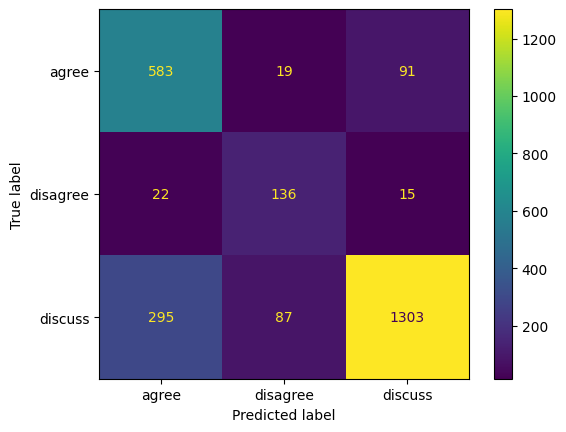

[2023-04-12 14:56:02] Classification Report:
[2023-04-12 14:56:02]               precision    recall  f1-score   support

           0       0.65      0.84      0.73       693
           1       0.56      0.79      0.66       173
           2       0.92      0.77      0.84      1685

    accuracy                           0.79      2551
   macro avg       0.71      0.80      0.74      2551
weighted avg       0.82      0.79      0.80      2551

[2023-04-12 14:56:02] Epoch Accuracy {'accuracy': 0.7926303410427283}
[2023-04-12 14:56:02] Finished validation evaluation
[2023-04-12 14:56:02] Beat best validation loss, new validation loss: 0.676996048119468 (surpassed 0.7187516227843339 from epoch 2)
[2023-04-12 14:56:03] Saved best model
[2023-04-12 14:56:03] Logged to wandb
[2023-04-12 14:56:03] Starting epoch 4
[2023-04-12 14:56:03] Starting epoch training
[2023-04-12 14:56:03] Set model to train mode


  0%|          | 0/1359 [00:00<?, ?it/s]

[2023-04-12 14:56:27][4:40] Loss: 0.097
[2023-04-12 14:56:51][4:80] Loss: 0.086
[2023-04-12 14:57:14][4:120] Loss: 0.106
[2023-04-12 14:57:38][4:160] Loss: 0.137
[2023-04-12 14:58:01][4:200] Loss: 0.078
[2023-04-12 14:58:25][4:240] Loss: 0.091
[2023-04-12 14:58:49][4:280] Loss: 0.098
[2023-04-12 14:59:12][4:320] Loss: 0.128
[2023-04-12 14:59:36][4:360] Loss: 0.101
[2023-04-12 15:00:00][4:400] Loss: 0.077
[2023-04-12 15:00:23][4:440] Loss: 0.041
[2023-04-12 15:00:47][4:480] Loss: 0.060
[2023-04-12 15:01:11][4:520] Loss: 0.094
[2023-04-12 15:01:34][4:560] Loss: 0.084
[2023-04-12 15:01:58][4:600] Loss: 0.072
[2023-04-12 15:02:21][4:640] Loss: 0.068
[2023-04-12 15:02:45][4:680] Loss: 0.066
[2023-04-12 15:03:09][4:720] Loss: 0.106
[2023-04-12 15:03:32][4:760] Loss: 0.077
[2023-04-12 15:03:56][4:800] Loss: 0.037
[2023-04-12 15:04:20][4:840] Loss: 0.064
[2023-04-12 15:04:43][4:880] Loss: 0.056
[2023-04-12 15:05:07][4:920] Loss: 0.063
[2023-04-12 15:05:31][4:960] Loss: 0.055
[2023-04-12 15:05:

  0%|          | 0/319 [00:00<?, ?it/s]

[2023-04-12 15:10:32] Set model to train mode


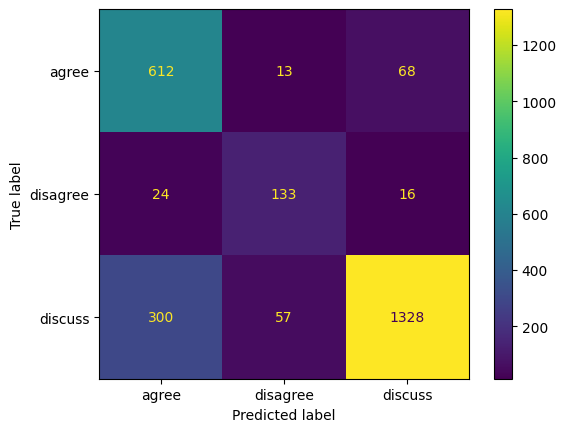

[2023-04-12 15:10:35] Classification Report:
[2023-04-12 15:10:35]               precision    recall  f1-score   support

           0       0.65      0.88      0.75       693
           1       0.66      0.77      0.71       173
           2       0.94      0.79      0.86      1685

    accuracy                           0.81      2551
   macro avg       0.75      0.81      0.77      2551
weighted avg       0.84      0.81      0.82      2551

[2023-04-12 15:10:35] Epoch Accuracy {'accuracy': 0.8126225009800079}
[2023-04-12 15:10:35] Finished validation evaluation
[2023-04-12 15:10:35] Beat best validation loss, new validation loss: 0.5981405067599166 (surpassed 0.676996048119468 from epoch 3)
[2023-04-12 15:10:36] Saved best model
[2023-04-12 15:10:36] Logged to wandb
[2023-04-12 15:10:36] Starting epoch 5
[2023-04-12 15:10:36] Starting epoch training
[2023-04-12 15:10:36] Set model to train mode


  0%|          | 0/1359 [00:00<?, ?it/s]

[2023-04-12 15:11:00][5:40] Loss: 0.077
[2023-04-12 15:11:24][5:80] Loss: 0.091
[2023-04-12 15:11:48][5:120] Loss: 0.050
[2023-04-12 15:12:11][5:160] Loss: 0.061
[2023-04-12 15:12:35][5:200] Loss: 0.059
[2023-04-12 15:12:59][5:240] Loss: 0.056
[2023-04-12 15:13:22][5:280] Loss: 0.028
[2023-04-12 15:13:46][5:320] Loss: 0.073
[2023-04-12 15:14:10][5:360] Loss: 0.036
[2023-04-12 15:14:33][5:400] Loss: 0.044
[2023-04-12 15:14:57][5:440] Loss: 0.093
[2023-04-12 15:15:20][5:480] Loss: 0.018
[2023-04-12 15:15:44][5:520] Loss: 0.092
[2023-04-12 15:16:08][5:560] Loss: 0.051
[2023-04-12 15:16:31][5:600] Loss: 0.020
[2023-04-12 15:16:55][5:640] Loss: 0.050
[2023-04-12 15:17:19][5:680] Loss: 0.018
[2023-04-12 15:17:42][5:720] Loss: 0.047
[2023-04-12 15:18:06][5:760] Loss: 0.090
[2023-04-12 15:18:30][5:800] Loss: 0.034
[2023-04-12 15:18:53][5:840] Loss: 0.037
[2023-04-12 15:19:17][5:880] Loss: 0.078
[2023-04-12 15:19:40][5:920] Loss: 0.062
[2023-04-12 15:20:04][5:960] Loss: 0.052
[2023-04-12 15:20:

  0%|          | 0/319 [00:00<?, ?it/s]

[2023-04-12 15:25:13] Set model to train mode


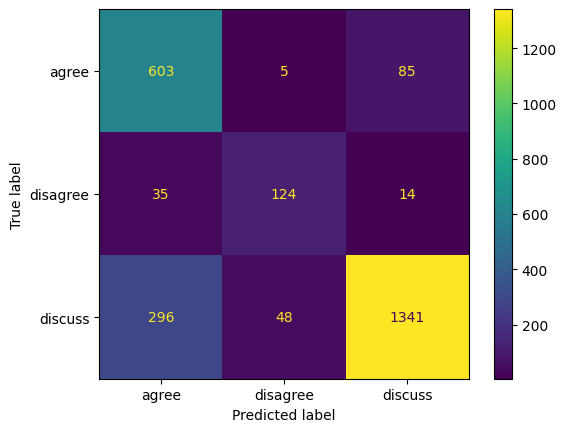

[2023-04-12 15:25:16] Classification Report:
[2023-04-12 15:25:16]               precision    recall  f1-score   support

           0       0.65      0.87      0.74       693
           1       0.70      0.72      0.71       173
           2       0.93      0.80      0.86      1685

    accuracy                           0.81      2551
   macro avg       0.76      0.79      0.77      2551
weighted avg       0.84      0.81      0.82      2551

[2023-04-12 15:25:16] Epoch Accuracy {'accuracy': 0.8106624852998824}
[2023-04-12 15:25:16] Finished validation evaluation
[2023-04-12 15:25:16] Logged to wandb
[2023-04-12 15:25:16] Starting epoch 6
[2023-04-12 15:25:16] Starting epoch training
[2023-04-12 15:25:16] Set model to train mode


  0%|          | 0/1359 [00:00<?, ?it/s]

[2023-04-12 15:25:41][6:40] Loss: 0.008
[2023-04-12 15:26:07][6:80] Loss: 0.118
[2023-04-12 15:26:31][6:120] Loss: 0.090
[2023-04-12 15:26:55][6:160] Loss: 0.063
[2023-04-12 15:27:22][6:200] Loss: 0.083
[2023-04-12 15:27:46][6:240] Loss: 0.046
[2023-04-12 15:28:10][6:280] Loss: 0.051
[2023-04-12 15:28:36][6:320] Loss: 0.045
[2023-04-12 15:29:02][6:360] Loss: 0.097
[2023-04-12 15:29:26][6:400] Loss: 0.057
[2023-04-12 15:29:50][6:440] Loss: 0.051
[2023-04-12 15:30:14][6:480] Loss: 0.063
[2023-04-12 15:30:38][6:520] Loss: 0.050
[2023-04-12 15:31:02][6:560] Loss: 0.054
[2023-04-12 15:31:27][6:600] Loss: 0.039
[2023-04-12 15:31:51][6:640] Loss: 0.055
[2023-04-12 15:32:16][6:680] Loss: 0.031
[2023-04-12 15:32:41][6:720] Loss: 0.048
[2023-04-12 15:33:06][6:760] Loss: 0.033
[2023-04-12 15:33:30][6:800] Loss: 0.021
[2023-04-12 15:33:54][6:840] Loss: 0.107
[2023-04-12 15:34:18][6:880] Loss: 0.052
[2023-04-12 15:34:41][6:920] Loss: 0.032
[2023-04-12 15:35:05][6:960] Loss: 0.045
[2023-04-12 15:35:

  0%|          | 0/319 [00:00<?, ?it/s]

[2023-04-12 15:40:07] Set model to train mode


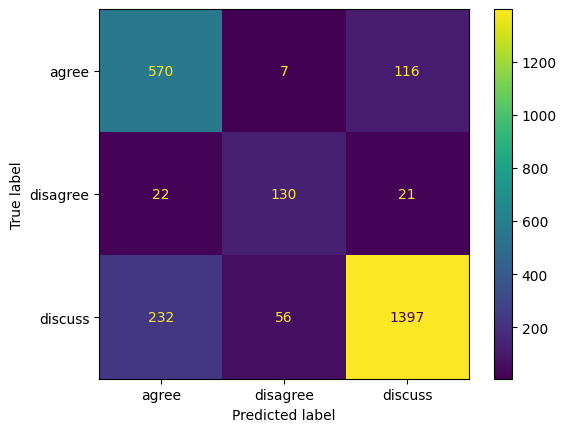

[2023-04-12 15:40:10] Classification Report:
[2023-04-12 15:40:10]               precision    recall  f1-score   support

           0       0.69      0.82      0.75       693
           1       0.67      0.75      0.71       173
           2       0.91      0.83      0.87      1685

    accuracy                           0.82      2551
   macro avg       0.76      0.80      0.78      2551
weighted avg       0.84      0.82      0.83      2551

[2023-04-12 15:40:10] Epoch Accuracy {'accuracy': 0.82203057624461}
[2023-04-12 15:40:10] Finished validation evaluation
[2023-04-12 15:40:10] Logged to wandb
[2023-04-12 15:40:10] Starting epoch 7
[2023-04-12 15:40:10] Starting epoch training
[2023-04-12 15:40:10] Set model to train mode


  0%|          | 0/1359 [00:00<?, ?it/s]

[2023-04-12 15:40:35][7:40] Loss: 0.021
[2023-04-12 15:40:58][7:80] Loss: 0.021
[2023-04-12 15:41:22][7:120] Loss: 0.017
[2023-04-12 15:41:45][7:160] Loss: 0.025
[2023-04-12 15:42:09][7:200] Loss: 0.036
[2023-04-12 15:42:33][7:240] Loss: 0.036
[2023-04-12 15:42:56][7:280] Loss: 0.026
[2023-04-12 15:43:20][7:320] Loss: 0.031
[2023-04-12 15:43:44][7:360] Loss: 0.042
[2023-04-12 15:44:07][7:400] Loss: 0.029
[2023-04-12 15:44:31][7:440] Loss: 0.021
[2023-04-12 15:44:55][7:480] Loss: 0.029
[2023-04-12 15:45:18][7:520] Loss: 0.030
[2023-04-12 15:45:42][7:560] Loss: 0.022
[2023-04-12 15:46:05][7:600] Loss: 0.059
[2023-04-12 15:46:29][7:640] Loss: 0.030
[2023-04-12 15:46:53][7:680] Loss: 0.072
[2023-04-12 15:47:16][7:720] Loss: 0.083
[2023-04-12 15:47:40][7:760] Loss: 0.011
[2023-04-12 15:48:04][7:800] Loss: 0.011
[2023-04-12 15:48:27][7:840] Loss: 0.011
[2023-04-12 15:48:51][7:880] Loss: 0.033
[2023-04-12 15:49:15][7:920] Loss: 0.047
[2023-04-12 15:49:38][7:960] Loss: 0.038
[2023-04-12 15:50:

  0%|          | 0/319 [00:00<?, ?it/s]

[2023-04-12 15:54:37] Set model to train mode


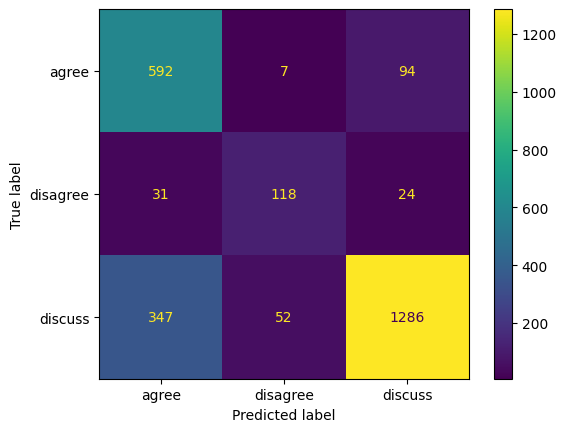

[2023-04-12 15:54:40] Classification Report:
[2023-04-12 15:54:40]               precision    recall  f1-score   support

           0       0.61      0.85      0.71       693
           1       0.67      0.68      0.67       173
           2       0.92      0.76      0.83      1685

    accuracy                           0.78      2551
   macro avg       0.73      0.77      0.74      2551
weighted avg       0.82      0.78      0.79      2551

[2023-04-12 15:54:40] Epoch Accuracy {'accuracy': 0.782438259506076}
[2023-04-12 15:54:40] Finished validation evaluation
[2023-04-12 15:54:40] Early stopping triggered, best validation loss achieved at 4 (loss: 0.5981405067599166)
[2023-04-12 15:54:40] Loading best model (epoch 0.5981405067599166) for evaluation
[2023-04-12 15:54:41] Starting test evaluation
[2023-04-12 15:54:41] Using model to generate predictions
[2023-04-12 15:54:41] Set model to eval mode


  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-12 15:57:37] Set model to train mode


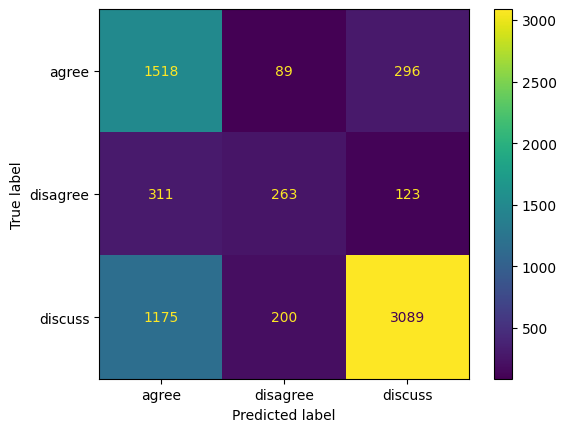

[2023-04-12 15:57:41] Classification Report:
[2023-04-12 15:57:41]               precision    recall  f1-score   support

           0       0.51      0.80      0.62      1903
           1       0.48      0.38      0.42       697
           2       0.88      0.69      0.77      4464

    accuracy                           0.69      7064
   macro avg       0.62      0.62      0.60      7064
weighted avg       0.74      0.69      0.70      7064

[2023-04-12 15:57:41] Finished test evaluation


In [118]:
model_trainer.train()

## Transformer+MLP

In [ ]:
class TransformerWithMLPHead(nn.Module):
    def __init__(self, bert, hidden_layers, hidden_dim, output_dim, dropout_prob):
        super().__init__()
        
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        if hidden_layers == 0:
            hidden_dim = [embedding_dim]
        else:
            if type(hidden_dim) is int:
                hidden_dim = [embedding_dim] + [hidden_dim] * hidden_layers
            else:
                hidden_dim = [embedding_dim] + hidden_dim
        
        layers = []
        
        for i in range(hidden_layers):
            layers += [
                nn.Linear(hidden_dim[i], hidden_dim[i + 1]),
                nn.Dropout(dropout_prob)
            ]
            
        if hidden_layers == 0:
            layers.append(nn.Dropout(dropout_prob))
        
        layers.append(nn.Linear(hidden_dim[-1], output_dim))
        
        self.head = nn.Sequential(*layers)
        
    def forward(self, input_ids, mask):
        with torch.no_grad():
            bert_embeddings = self.bert(input_ids, attention_mask=mask)[0][:, 0, :]
        
        output = self.head(bert_embeddings)
        return output

In [ ]:
bert = BertModel.from_pretrained(selected_model)
bert = bert.to(device)

model_trainer = TransformerBasedModelTrainer(
    model_class=TransformerWithMLPHead,
    model_transformer=bert,
    model_freeze_transformer=False,
    model_config={
        "hidden_layers": 0,
        "hidden_dim": [],
        "output_dim": 3,
        "dropout_prob": 0.2
    },
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=100,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn=None,
    no_improvement_epochs_stop=3,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0"
)

In [ ]:
model_trainer.train()

## Their BERT MLP

In [94]:
class TransformerMLPDummy(nn.Module):
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        
    def forward(self, input_ids, mask):
        out = self.bert(input_ids, attention_mask=mask)
        return out["logits"]

In [95]:
from transformers import BertForSequenceClassification

bert = BertForSequenceClassification.from_pretrained(
    selected_model,
    num_labels=3
)

model_trainer = my_trainer.TransformerBasedModelTrainer(
    model_class=TransformerMLPDummy,
    model_transformer=bert,
    model_freeze_transformer=False,
    model_config={},
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 10 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=10,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn="inverse",
    no_improvement_epochs_stop=3,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0"
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model Initialised
Model Initialised
Loss Initialised
Unique labels [0, 1, 2]
Calculated inverse
Distribution [3.6435510887772193, 16.30584707646177, 1.5055370985603544]
Normalised Distribution [0.16982344826390317, 0.7600044873579476, 0.07017206437814937]
Train Data Sampler Initialised
Dataloaders Initialised
Dumped Config


[2023-04-12 12:23:48] Starting epoch 1
[2023-04-12 12:23:48] Starting epoch training
[2023-04-12 12:23:48] Set model to train mode


  0%|          | 0/1359 [00:00<?, ?it/s]

[2023-04-12 12:24:09][1:40] Loss: 0.791
[2023-04-12 12:24:30][1:80] Loss: 0.713
[2023-04-12 12:24:50][1:120] Loss: 0.692
[2023-04-12 12:25:10][1:160] Loss: 0.724
[2023-04-12 12:25:30][1:200] Loss: 0.753
[2023-04-12 12:25:51][1:240] Loss: 0.807
[2023-04-12 12:26:11][1:280] Loss: 0.654
[2023-04-12 12:26:31][1:320] Loss: 0.664
[2023-04-12 12:26:51][1:360] Loss: 0.633
[2023-04-12 12:27:12][1:400] Loss: 0.713
[2023-04-12 12:27:33][1:440] Loss: 0.761
[2023-04-12 12:27:54][1:480] Loss: 0.660
[2023-04-12 12:28:15][1:520] Loss: 0.708
[2023-04-12 12:28:36][1:560] Loss: 0.624
[2023-04-12 12:28:57][1:600] Loss: 0.639
[2023-04-12 12:29:17][1:640] Loss: 0.661
[2023-04-12 12:29:38][1:680] Loss: 0.662
[2023-04-12 12:29:59][1:720] Loss: 0.667
[2023-04-12 12:30:20][1:760] Loss: 0.666
[2023-04-12 12:30:41][1:800] Loss: 0.709
[2023-04-12 12:31:01][1:840] Loss: 0.660
[2023-04-12 12:31:22][1:880] Loss: 0.737
[2023-04-12 12:31:43][1:920] Loss: 0.729
[2023-04-12 12:32:04][1:960] Loss: 0.741
[2023-04-12 12:32:

  0%|          | 0/319 [00:00<?, ?it/s]

[2023-04-12 12:36:23] Set model to train mode


F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

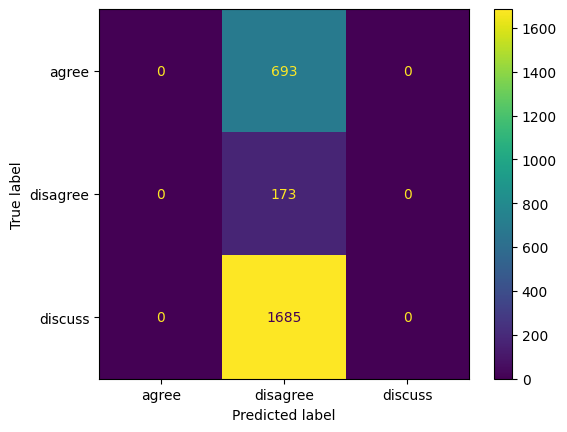

[2023-04-12 12:36:26] Classification Report:
[2023-04-12 12:36:26]               precision    recall  f1-score   support

           0       0.00      0.00      0.00       693
           1       0.07      1.00      0.13       173
           2       0.00      0.00      0.00      1685

    accuracy                           0.07      2551
   macro avg       0.02      0.33      0.04      2551
weighted avg       0.00      0.07      0.01      2551

[2023-04-12 12:36:26] Epoch Accuracy {'accuracy': 0.06781654253234026}
[2023-04-12 12:36:26] Finished validation evaluation
[2023-04-12 12:36:26] Beat best validation loss, new validation loss: 2.26084501111769 (surpassed 1000000000.0 from epoch -1)


F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[2023-04-12 12:36:28] Saved best model
[2023-04-12 12:36:28] Logged to wandb
[2023-04-12 12:36:28] Starting epoch 2
[2023-04-12 12:36:28] Starting epoch training
[2023-04-12 12:36:28] Set model to train mode


  0%|          | 0/1359 [00:00<?, ?it/s]

[2023-04-12 12:36:48][2:40] Loss: 0.787
[2023-04-12 12:37:09][2:80] Loss: 0.683
[2023-04-12 12:37:29][2:120] Loss: 0.722
[2023-04-12 12:37:49][2:160] Loss: 0.739
[2023-04-12 12:38:09][2:200] Loss: 0.612
[2023-04-12 12:38:29][2:240] Loss: 0.754
[2023-04-12 12:38:50][2:280] Loss: 0.632
[2023-04-12 12:39:10][2:320] Loss: 0.694
[2023-04-12 12:39:30][2:360] Loss: 0.712
[2023-04-12 12:39:50][2:400] Loss: 0.681
[2023-04-12 12:40:11][2:440] Loss: 0.760
[2023-04-12 12:40:31][2:480] Loss: 0.717
[2023-04-12 12:40:51][2:520] Loss: 0.749
[2023-04-12 12:41:11][2:560] Loss: 0.759
[2023-04-12 12:41:32][2:600] Loss: 0.734
[2023-04-12 12:41:52][2:640] Loss: 0.743
[2023-04-12 12:42:12][2:680] Loss: 0.679
[2023-04-12 12:42:32][2:720] Loss: 0.716
[2023-04-12 12:42:53][2:760] Loss: 0.674
[2023-04-12 12:43:13][2:800] Loss: 0.687
[2023-04-12 12:43:33][2:840] Loss: 0.719
[2023-04-12 12:43:53][2:880] Loss: 0.700
[2023-04-12 12:44:14][2:920] Loss: 0.653
[2023-04-12 12:44:34][2:960] Loss: 0.655
[2023-04-12 12:44:

  0%|          | 0/319 [00:00<?, ?it/s]

[2023-04-12 12:48:47] Set model to train mode


F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

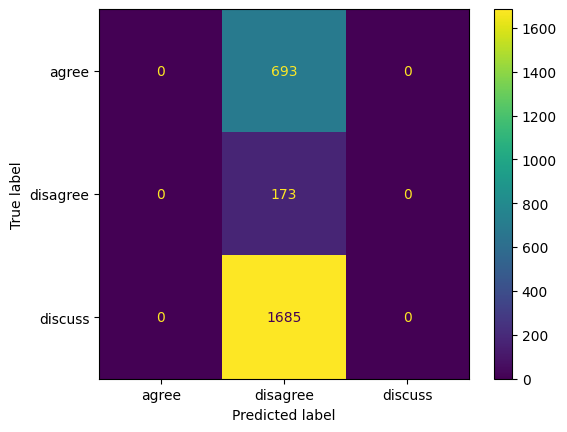

[2023-04-12 12:48:51] Classification Report:
[2023-04-12 12:48:51]               precision    recall  f1-score   support

           0       0.00      0.00      0.00       693
           1       0.07      1.00      0.13       173
           2       0.00      0.00      0.00      1685

    accuracy                           0.07      2551
   macro avg       0.02      0.33      0.04      2551
weighted avg       0.00      0.07      0.01      2551

[2023-04-12 12:48:51] Epoch Accuracy {'accuracy': 0.06781654253234026}
[2023-04-12 12:48:51] Finished validation evaluation
[2023-04-12 12:48:51] Beat best validation loss, new validation loss: 2.1794836347379656 (surpassed 2.26084501111769 from epoch 1)


F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
F:\Documents\Development\GitHub\natural-language-processing-y4\code\env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

[2023-04-12 12:48:52] Saved best model
[2023-04-12 12:48:52] Logged to wandb
[2023-04-12 12:48:52] Starting epoch 3
[2023-04-12 12:48:52] Starting epoch training
[2023-04-12 12:48:52] Set model to train mode


  0%|          | 0/1359 [00:00<?, ?it/s]

[2023-04-12 12:49:13][3:40] Loss: 0.726
[2023-04-12 12:49:33][3:80] Loss: 0.669
[2023-04-12 12:49:54][3:120] Loss: 0.759
[2023-04-12 12:50:14][3:160] Loss: 0.625
[2023-04-12 12:50:34][3:200] Loss: 0.649
[2023-04-12 12:50:54][3:240] Loss: 0.780
[2023-04-12 12:51:15][3:280] Loss: 0.763
[2023-04-12 12:51:35][3:320] Loss: 0.731
[2023-04-12 12:51:55][3:360] Loss: 0.729
[2023-04-12 12:52:17][3:400] Loss: 0.672


KeyboardInterrupt: 

In [96]:
model_trainer.train()

## BERT+CNN

In [145]:
class BERTWithCNN(nn.Module):
    def __init__(self, bert):
        super().__init__()
        
        self.bert = bert
        embedding_dim = bert.config.to_dict()["hidden_size"]
        
        # self.layers = nn.Sequential(
        #     # nn.Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1)),
        #     # nn.ReLU(),
        #     # nn.Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1)),
        #     # nn.ReLU(),
        #     # nn.Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1)),
        #     # nn.ReLU(),
        #     # nn.Conv1d(in_channels=768, out_channels=384, kernel_size=5, padding="valid", stride=1),
        #     # nn.ReLU(),
        #     # nn.MaxPool1d(kernel_size= 64- 5 + 1),
        #     # nn.Dropout(0.2),
        #     # nn.Linear(384, 192),
        #     # nn.Linear(192, 3)
        # )
        
        # self.lstm = nn.LSTM(
        
        self.first_conv = nn.Sequential(
            nn.Conv1d(768, 512, 5, padding=2),
            nn.ReLU(),
            # nn.MaxPool1d(256 + 1)
        )
        
        self.second_conv = nn.Sequential(
            nn.Conv1d(512, 256, 5, padding=2),
            nn.ReLU(),
            # nn.MaxPool1d(256 + 1)
        )
        
        self.rnn = nn.GRU(256,
                          256,
                          num_layers = 2,
                          bidirectional = True,
                          batch_first = True,
                          dropout = 0.2)
        
        self.out = nn.Linear(256 * 2, 3)
        
        self.dropout = nn.Dropout(0.2)
        
        # self.conv = nn.Conv1d(768, 384, 5, padding=2)
    
    def forward(self, ids, mask):
        embedded = self.bert(input_ids=ids, attention_mask=mask)[0]
        
        # (b, 512, 768)
        # print("BERT Embeddings (N, L, C)", embedded.shape)
        
        embedded = embedded.permute(0, 2, 1)
        # print("Rearranged to (N, C, L)", embedded.shape)
        
        x = self.first_conv(embedded)
        # print("After Conv", x.shape)
        
        x = self.second_conv(x)
        # print("After Conv 2", x.shape)
        
        x = x.permute(0, 2, 1)
        # print("Rearranged to (N, L, C)", embedded.shape)
        
        
        _, hidden = self.rnn(x)
    
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        
        output = self.out(hidden)        
        
        return output
        
        # processed = processed.permute(0, 2, 1)
        # print(processed.shape)
        # embedded = embedded.permute(0, 2, 1)
        
        #x = self.layers(embedded)
        #print(x.shape)
        

In [148]:
bert = BertModel.from_pretrained(selected_model)
bert = bert.to(device)

model_trainer = my_trainer.TransformerBasedModelTrainer(
    model_class=BERTWithCNN,
    model_transformer=bert,
    model_freeze_transformer=False,
    model_config={},
    optimiser_class=optim.AdamW,
    optimiser_config={
        "lr": 5e-5
    },
    hf_scheduler_name="linear",
    hf_scheduler_config={
        "num_warmup_steps": 0,
        "num_training_steps": 10 * (len(train_dataset) + 1) // 8
    },
    loss_class=nn.CrossEntropyLoss,
    batch_size=8,
    max_epochs=10,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    label_names=list(labels2id.keys()),
    sampling_weight_fn=[0.25, 0.25, 0.125],
    no_improvement_epochs_stop=3,
    eval_batch_size=None,
    loss_weights=None,
    device="cuda:0"
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model Initialised
Model Initialised
Loss Initialised
Unique labels [0, 1, 2]
Distribution [0.25, 0.25, 0.125]
Normalised Distribution [0.4, 0.4, 0.2]
Train Data Sampler Initialised
Dataloaders Initialised
Dumped Config


[2023-04-12 20:25:19] Starting epoch 1
[2023-04-12 20:25:19] Starting epoch training
[2023-04-12 20:25:19] Set model to train mode


  0%|          | 0/1359 [00:00<?, ?it/s]

[2023-04-12 20:25:43][1:40] Loss: 1.095
[2023-04-12 20:26:06][1:80] Loss: 0.973
[2023-04-12 20:26:29][1:120] Loss: 0.855
[2023-04-12 20:26:53][1:160] Loss: 0.802
[2023-04-12 20:27:16][1:200] Loss: 0.780
[2023-04-12 20:27:39][1:240] Loss: 0.718
[2023-04-12 20:28:02][1:280] Loss: 0.765
[2023-04-12 20:28:25][1:320] Loss: 0.705
[2023-04-12 20:28:48][1:360] Loss: 0.632
[2023-04-12 20:29:12][1:400] Loss: 0.666
[2023-04-12 20:29:35][1:440] Loss: 0.584
[2023-04-12 20:29:58][1:480] Loss: 0.670
[2023-04-12 20:30:21][1:520] Loss: 0.619
[2023-04-12 20:30:44][1:560] Loss: 0.587
[2023-04-12 20:31:08][1:600] Loss: 0.505
[2023-04-12 20:31:31][1:640] Loss: 0.557
[2023-04-12 20:31:54][1:680] Loss: 0.501
[2023-04-12 20:32:17][1:720] Loss: 0.523
[2023-04-12 20:32:40][1:760] Loss: 0.490
[2023-04-12 20:33:03][1:800] Loss: 0.513
[2023-04-12 20:33:27][1:840] Loss: 0.364
[2023-04-12 20:33:50][1:880] Loss: 0.505
[2023-04-12 20:34:13][1:920] Loss: 0.427
[2023-04-12 20:34:36][1:960] Loss: 0.428
[2023-04-12 20:34:

  0%|          | 0/319 [00:00<?, ?it/s]

[2023-04-12 20:39:26] Set model to train mode


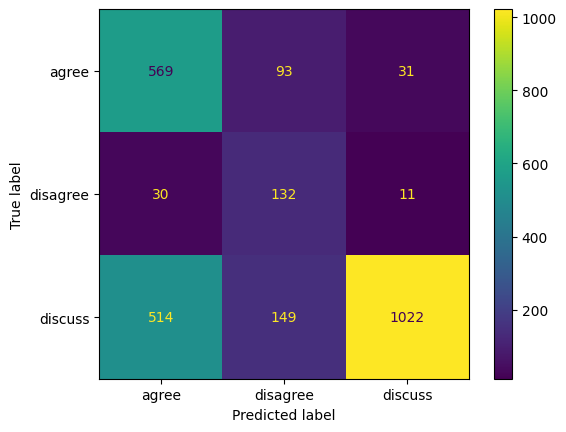

[2023-04-12 20:39:30] Classification Report:
[2023-04-12 20:39:30]               precision    recall  f1-score   support

           0       0.51      0.82      0.63       693
           1       0.35      0.76      0.48       173
           2       0.96      0.61      0.74      1685

    accuracy                           0.68      2551
   macro avg       0.61      0.73      0.62      2551
weighted avg       0.80      0.68      0.70      2551

[2023-04-12 20:39:30] Epoch Accuracy {'accuracy': 0.675421403371227}
[2023-04-12 20:39:30] Finished validation evaluation
[2023-04-12 20:39:30] Beat best validation loss, new validation loss: 0.8610193000341471 (surpassed 1000000000.0 from epoch -1)
[2023-04-12 20:39:31] Saved best model
[2023-04-12 20:39:31] Logged to wandb
[2023-04-12 20:39:31] Starting epoch 2
[2023-04-12 20:39:31] Starting epoch training
[2023-04-12 20:39:31] Set model to train mode


  0%|          | 0/1359 [00:00<?, ?it/s]

[2023-04-12 20:39:55][2:40] Loss: 0.327
[2023-04-12 20:40:17][2:80] Loss: 0.342
[2023-04-12 20:40:40][2:120] Loss: 0.345
[2023-04-12 20:41:02][2:160] Loss: 0.263
[2023-04-12 20:41:25][2:200] Loss: 0.309
[2023-04-12 20:41:48][2:240] Loss: 0.258
[2023-04-12 20:42:10][2:280] Loss: 0.320
[2023-04-12 20:42:33][2:320] Loss: 0.317
[2023-04-12 20:42:56][2:360] Loss: 0.212
[2023-04-12 20:43:18][2:400] Loss: 0.258
[2023-04-12 20:43:41][2:440] Loss: 0.238
[2023-04-12 20:44:03][2:480] Loss: 0.233
[2023-04-12 20:44:26][2:520] Loss: 0.243
[2023-04-12 20:44:49][2:560] Loss: 0.213
[2023-04-12 20:45:11][2:600] Loss: 0.280
[2023-04-12 20:45:34][2:640] Loss: 0.217
[2023-04-12 20:45:57][2:680] Loss: 0.250
[2023-04-12 20:46:19][2:720] Loss: 0.180
[2023-04-12 20:46:42][2:760] Loss: 0.162
[2023-04-12 20:47:05][2:800] Loss: 0.185
[2023-04-12 20:47:27][2:840] Loss: 0.231
[2023-04-12 20:47:50][2:880] Loss: 0.151
[2023-04-12 20:48:12][2:920] Loss: 0.202
[2023-04-12 20:48:35][2:960] Loss: 0.158
[2023-04-12 20:48:

  0%|          | 0/319 [00:00<?, ?it/s]

[2023-04-12 20:53:20] Set model to train mode


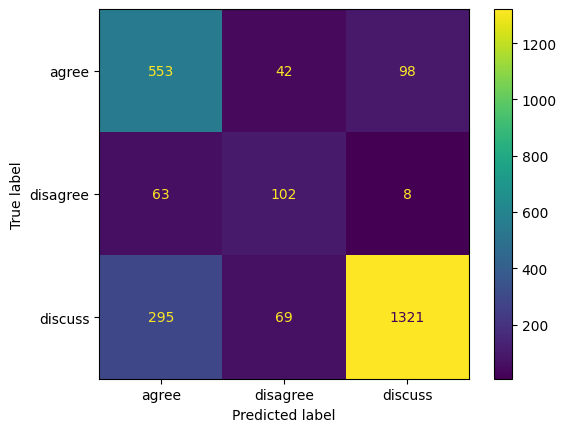

[2023-04-12 20:53:23] Classification Report:
[2023-04-12 20:53:23]               precision    recall  f1-score   support

           0       0.61      0.80      0.69       693
           1       0.48      0.59      0.53       173
           2       0.93      0.78      0.85      1685

    accuracy                           0.77      2551
   macro avg       0.67      0.72      0.69      2551
weighted avg       0.81      0.77      0.78      2551

[2023-04-12 20:53:23] Epoch Accuracy {'accuracy': 0.7745981967855743}
[2023-04-12 20:53:23] Finished validation evaluation
[2023-04-12 20:53:23] Beat best validation loss, new validation loss: 0.68181134019701 (surpassed 0.8610193000341471 from epoch 1)
[2023-04-12 20:53:24] Saved best model
[2023-04-12 20:53:24] Logged to wandb
[2023-04-12 20:53:24] Starting epoch 3
[2023-04-12 20:53:24] Starting epoch training
[2023-04-12 20:53:24] Set model to train mode


  0%|          | 0/1359 [00:00<?, ?it/s]

[2023-04-12 20:53:48][3:40] Loss: 0.114
[2023-04-12 20:54:10][3:80] Loss: 0.118
[2023-04-12 20:54:33][3:120] Loss: 0.195
[2023-04-12 20:54:55][3:160] Loss: 0.150
[2023-04-12 20:55:18][3:200] Loss: 0.156
[2023-04-12 20:55:41][3:240] Loss: 0.067
[2023-04-12 20:56:03][3:280] Loss: 0.164
[2023-04-12 20:56:26][3:320] Loss: 0.163
[2023-04-12 20:56:49][3:360] Loss: 0.106
[2023-04-12 20:57:11][3:400] Loss: 0.199
[2023-04-12 20:57:34][3:440] Loss: 0.118
[2023-04-12 20:57:57][3:480] Loss: 0.155
[2023-04-12 20:58:19][3:520] Loss: 0.160
[2023-04-12 20:58:42][3:560] Loss: 0.167
[2023-04-12 20:59:05][3:600] Loss: 0.147
[2023-04-12 20:59:27][3:640] Loss: 0.138
[2023-04-12 20:59:50][3:680] Loss: 0.117
[2023-04-12 21:00:12][3:720] Loss: 0.081
[2023-04-12 21:00:35][3:760] Loss: 0.122
[2023-04-12 21:00:58][3:800] Loss: 0.094
[2023-04-12 21:01:20][3:840] Loss: 0.127
[2023-04-12 21:01:43][3:880] Loss: 0.045
[2023-04-12 21:02:06][3:920] Loss: 0.087
[2023-04-12 21:02:28][3:960] Loss: 0.148
[2023-04-12 21:02:

  0%|          | 0/319 [00:00<?, ?it/s]

[2023-04-12 21:07:13] Set model to train mode


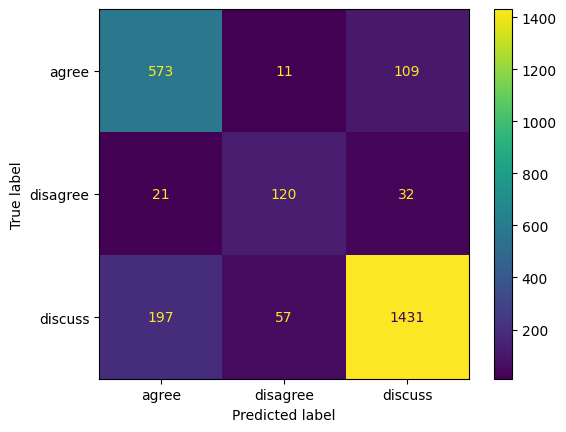

[2023-04-12 21:07:16] Classification Report:
[2023-04-12 21:07:16]               precision    recall  f1-score   support

           0       0.72      0.83      0.77       693
           1       0.64      0.69      0.66       173
           2       0.91      0.85      0.88      1685

    accuracy                           0.83      2551
   macro avg       0.76      0.79      0.77      2551
weighted avg       0.84      0.83      0.84      2551

[2023-04-12 21:07:16] Epoch Accuracy {'accuracy': 0.8326146609172873}
[2023-04-12 21:07:16] Finished validation evaluation
[2023-04-12 21:07:16] Beat best validation loss, new validation loss: 0.6496915617540951 (surpassed 0.68181134019701 from epoch 2)
[2023-04-12 21:07:18] Saved best model
[2023-04-12 21:07:18] Logged to wandb
[2023-04-12 21:07:18] Starting epoch 4
[2023-04-12 21:07:18] Starting epoch training
[2023-04-12 21:07:18] Set model to train mode


  0%|          | 0/1359 [00:00<?, ?it/s]

[2023-04-12 21:07:41][4:40] Loss: 0.079
[2023-04-12 21:08:03][4:80] Loss: 0.096
[2023-04-12 21:08:26][4:120] Loss: 0.131
[2023-04-12 21:08:49][4:160] Loss: 0.119
[2023-04-12 21:09:12][4:200] Loss: 0.039
[2023-04-12 21:09:34][4:240] Loss: 0.064
[2023-04-12 21:09:57][4:280] Loss: 0.112
[2023-04-12 21:10:19][4:320] Loss: 0.157
[2023-04-12 21:10:42][4:360] Loss: 0.072
[2023-04-12 21:11:05][4:400] Loss: 0.081
[2023-04-12 21:11:27][4:440] Loss: 0.060
[2023-04-12 21:11:50][4:480] Loss: 0.073
[2023-04-12 21:12:13][4:520] Loss: 0.122
[2023-04-12 21:12:35][4:560] Loss: 0.109
[2023-04-12 21:12:58][4:600] Loss: 0.088
[2023-04-12 21:13:21][4:640] Loss: 0.065
[2023-04-12 21:13:43][4:680] Loss: 0.063
[2023-04-12 21:14:06][4:720] Loss: 0.023
[2023-04-12 21:14:29][4:760] Loss: 0.088
[2023-04-12 21:14:51][4:800] Loss: 0.053
[2023-04-12 21:15:14][4:840] Loss: 0.066
[2023-04-12 21:15:36][4:880] Loss: 0.043
[2023-04-12 21:15:59][4:920] Loss: 0.079
[2023-04-12 21:16:22][4:960] Loss: 0.059
[2023-04-12 21:16:

  0%|          | 0/319 [00:00<?, ?it/s]

[2023-04-12 21:21:06] Set model to train mode


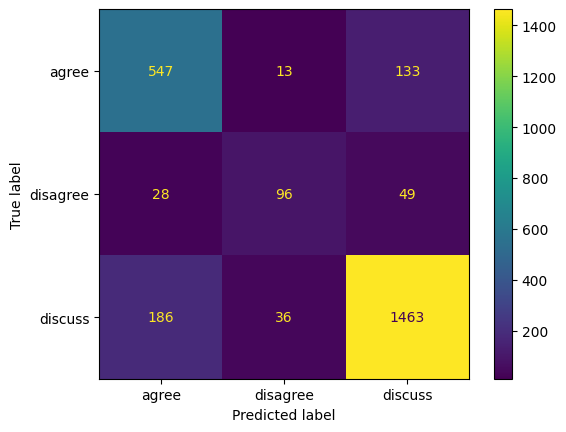

[2023-04-12 21:21:10] Classification Report:
[2023-04-12 21:21:10]               precision    recall  f1-score   support

           0       0.72      0.79      0.75       693
           1       0.66      0.55      0.60       173
           2       0.89      0.87      0.88      1685

    accuracy                           0.83      2551
   macro avg       0.76      0.74      0.74      2551
weighted avg       0.83      0.83      0.83      2551

[2023-04-12 21:21:10] Epoch Accuracy {'accuracy': 0.8255586044688358}
[2023-04-12 21:21:10] Finished validation evaluation
[2023-04-12 21:21:10] Logged to wandb
[2023-04-12 21:21:10] Starting epoch 5
[2023-04-12 21:21:10] Starting epoch training
[2023-04-12 21:21:10] Set model to train mode


  0%|          | 0/1359 [00:00<?, ?it/s]

[2023-04-12 21:21:33][5:40] Loss: 0.103
[2023-04-12 21:21:56][5:80] Loss: 0.073
[2023-04-12 21:22:18][5:120] Loss: 0.069
[2023-04-12 21:22:41][5:160] Loss: 0.043
[2023-04-12 21:23:04][5:200] Loss: 0.074
[2023-04-12 21:23:26][5:240] Loss: 0.037
[2023-04-12 21:23:49][5:280] Loss: 0.059
[2023-04-12 21:24:12][5:320] Loss: 0.050
[2023-04-12 21:24:34][5:360] Loss: 0.053
[2023-04-12 21:24:57][5:400] Loss: 0.099
[2023-04-12 21:25:20][5:440] Loss: 0.024
[2023-04-12 21:25:42][5:480] Loss: 0.062
[2023-04-12 21:26:05][5:520] Loss: 0.031
[2023-04-12 21:26:27][5:560] Loss: 0.022
[2023-04-12 21:26:50][5:600] Loss: 0.041
[2023-04-12 21:27:13][5:640] Loss: 0.046
[2023-04-12 21:27:35][5:680] Loss: 0.046
[2023-04-12 21:27:58][5:720] Loss: 0.044
[2023-04-12 21:28:21][5:760] Loss: 0.038
[2023-04-12 21:28:43][5:800] Loss: 0.007
[2023-04-12 21:29:06][5:840] Loss: 0.046
[2023-04-12 21:29:29][5:880] Loss: 0.049
[2023-04-12 21:29:51][5:920] Loss: 0.067
[2023-04-12 21:30:14][5:960] Loss: 0.053
[2023-04-12 21:30:

  0%|          | 0/319 [00:00<?, ?it/s]

[2023-04-12 21:34:59] Set model to train mode


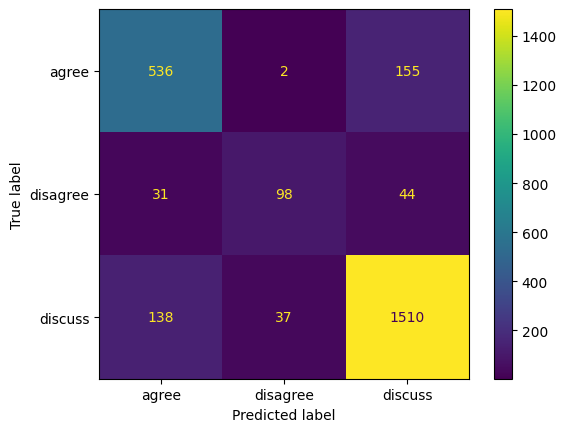

[2023-04-12 21:35:02] Classification Report:
[2023-04-12 21:35:02]               precision    recall  f1-score   support

           0       0.76      0.77      0.77       693
           1       0.72      0.57      0.63       173
           2       0.88      0.90      0.89      1685

    accuracy                           0.84      2551
   macro avg       0.79      0.75      0.76      2551
weighted avg       0.84      0.84      0.84      2551

[2023-04-12 21:35:02] Epoch Accuracy {'accuracy': 0.8404547236377891}
[2023-04-12 21:35:02] Finished validation evaluation
[2023-04-12 21:35:02] Logged to wandb
[2023-04-12 21:35:02] Starting epoch 6
[2023-04-12 21:35:02] Starting epoch training
[2023-04-12 21:35:02] Set model to train mode


  0%|          | 0/1359 [00:00<?, ?it/s]

[2023-04-12 21:35:25][6:40] Loss: 0.054
[2023-04-12 21:35:48][6:80] Loss: 0.035
[2023-04-12 21:36:13][6:120] Loss: 0.062
[2023-04-12 21:36:38][6:160] Loss: 0.072
[2023-04-12 21:37:01][6:200] Loss: 0.126
[2023-04-12 21:37:24][6:240] Loss: 0.047
[2023-04-12 21:37:47][6:280] Loss: 0.019
[2023-04-12 21:38:10][6:320] Loss: 0.050
[2023-04-12 21:38:33][6:360] Loss: 0.029
[2023-04-12 21:38:56][6:400] Loss: 0.020
[2023-04-12 21:39:20][6:440] Loss: 0.024
[2023-04-12 21:39:43][6:480] Loss: 0.028
[2023-04-12 21:40:06][6:520] Loss: 0.018
[2023-04-12 21:40:29][6:560] Loss: 0.024
[2023-04-12 21:40:52][6:600] Loss: 0.041
[2023-04-12 21:41:15][6:640] Loss: 0.060
[2023-04-12 21:41:38][6:680] Loss: 0.034
[2023-04-12 21:42:01][6:720] Loss: 0.012
[2023-04-12 21:42:24][6:760] Loss: 0.021
[2023-04-12 21:42:47][6:800] Loss: 0.075
[2023-04-12 21:43:10][6:840] Loss: 0.035
[2023-04-12 21:43:33][6:880] Loss: 0.013
[2023-04-12 21:43:56][6:920] Loss: 0.041
[2023-04-12 21:44:19][6:960] Loss: 0.030
[2023-04-12 21:44:

  0%|          | 0/319 [00:00<?, ?it/s]

[2023-04-12 21:49:09] Set model to train mode


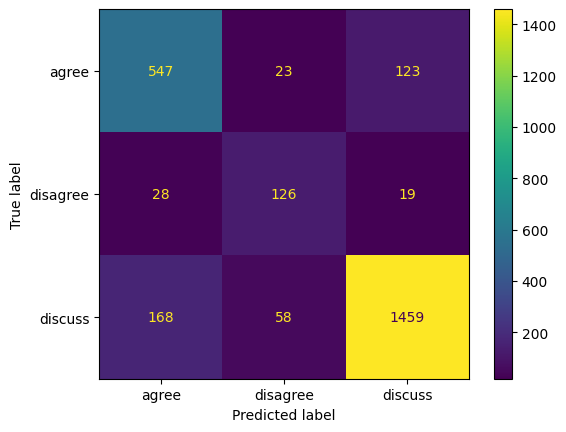

[2023-04-12 21:49:12] Classification Report:
[2023-04-12 21:49:12]               precision    recall  f1-score   support

           0       0.74      0.79      0.76       693
           1       0.61      0.73      0.66       173
           2       0.91      0.87      0.89      1685

    accuracy                           0.84      2551
   macro avg       0.75      0.79      0.77      2551
weighted avg       0.84      0.84      0.84      2551

[2023-04-12 21:49:12] Epoch Accuracy {'accuracy': 0.8357506860054881}
[2023-04-12 21:49:12] Finished validation evaluation
[2023-04-12 21:49:12] Early stopping triggered, best validation loss achieved at 3 (loss: 0.6496915617540951)
[2023-04-12 21:49:12] Loading best model (epoch 0.6496915617540951) for evaluation
[2023-04-12 21:49:12] Starting test evaluation
[2023-04-12 21:49:12] Using model to generate predictions
[2023-04-12 21:49:12] Set model to eval mode


  0%|          | 0/883 [00:00<?, ?it/s]

[2023-04-12 21:51:56] Set model to train mode


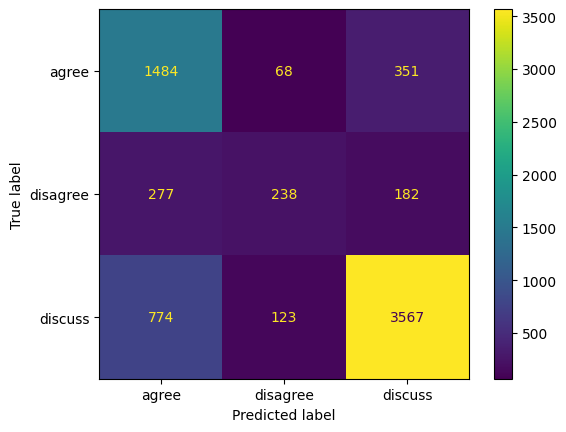

[2023-04-12 21:52:00] Classification Report:
[2023-04-12 21:52:00]               precision    recall  f1-score   support

           0       0.59      0.78      0.67      1903
           1       0.55      0.34      0.42       697
           2       0.87      0.80      0.83      4464

    accuracy                           0.75      7064
   macro avg       0.67      0.64      0.64      7064
weighted avg       0.76      0.75      0.75      7064

[2023-04-12 21:52:00] Finished test evaluation


In [149]:
model_trainer.train()